<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#什么是最优子集回归?" data-toc-modified-id="什么是最优子集回归?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>什么是最优子集回归?</a></span></li><li><span><a href="#如何获得全部模型?" data-toc-modified-id="如何获得全部模型?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>如何获得全部模型?</a></span><ul class="toc-item"><li><span><a href="#循环法获得矩阵$Z$" data-toc-modified-id="循环法获得矩阵$Z$-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>循环法获得矩阵$Z$</a></span></li><li><span><a href="#递归法获得矩阵$Z$" data-toc-modified-id="递归法获得矩阵$Z$-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>递归法获得矩阵$Z$</a></span></li></ul></li><li><span><a href="#R语言实现最优子集回归" data-toc-modified-id="R语言实现最优子集回归-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>R语言实现最优子集回归</a></span></li><li><span><a href="#例子" data-toc-modified-id="例子-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>例子</a></span></li></ul></div>

# 最优子集回归

## 什么是最优子集回归?

- 当我们进行回归分析时，我们可能会碰到自变量过多, 且存在多重共线性, 或者全模型可能是过度拟合的.
- 针对这种情况，可以人为根据经验判断筛选对因变量有影响的自变量，比如距离周边学校的距离去预测房价.
- 但通常我们并不是相关领域的专家, 对可能影响因变量的自变量并不了解，于是我们需要运用算法获得预测效果最优的模型, 进而接近真实模型，比如最优子集回归.
    - 最优子集回归, 即对$p$个预测变量的所有可能组合分别使用最小二乘回归进行拟合
    - 对含1变量的模型，拟合$p$个模型; 对含两个变量的模型，拟合$p(p-1)/2$个模型，以此类推，总共拟合$2^p$个模型.
    - 按照一定的比较准则（如AIC）从中选择一个最优模型.

## 如何获得全部模型?

- 最优子集回归需要建立大量的模型，手动输入显然不可行，可以使用二进制向量来表示一个模型，值为1表示选择该变量，值为0表示不选择该变量. 
- 比如总共有3个自变量时，$(0,1,1)$表示使用第2和第3个自变量建立模型.
- 将所有可能的向量按行排列，得到$2^p\times p$维的矩阵$Z$.
- 矩阵$Z$的行转化为十进制即为$[0,2^p-1]$的所有整数，所以，$[0,2^p-1]$中的所有整数转化为二进制向量并按行排列即可表示所有可能的模型.

### 循环法获得矩阵$Z$

- 解方程$(1)$，得到$(k_0,k_1,...,k_{p-1})$, 即可将十进制的$n$转化为二进制$p$维向量。
$$n=k_02^0+k_12^1+k_22^2+...+k_{p-1}2^{p-1}\tag{1}$$
- <font face="黑体"> turnbits_cir </font>函数即可实现此功能。

In [19]:
##turnbits_cir函数用于将十进制转化为p维二进制向量
##参数n为十进制数，p为二进制向量维数
##输出p维逻辑行向量
turnbits_cir = function(n,p){
    
  z = rep(0,p)           #预留空间
  tn = n                 #tn为十进制数值
  z[1] = tn%%2           #tn/2的余数为z的第一个值
    
  for(j in 2:p){         
    tn = (tn-z[j-1])/2   #更新tn的值
    if(tn == 0) break    #tn=0时跳出循环
    z[j] = tn%%2         #z的第j个值为tn/2的余数
  }
    
  as.logical(z)          #将向量z转化为逻辑值
}

##以p=3为例
p = 3

Z = matrix(unlist(lapply(0:(2^p-1) , turnbits_cir , p)) ,   #将0：2^p-1转化为p维二进制向量，并按行排列
           ncol = p ,byrow = T)
Z

unlist(lapply(0:(2^p-1) , turnbits_cir , p))
lapply(0:(2^p-1) , turnbits_cir , p)

FALSE,FALSE,FALSE
TRUE,FALSE,FALSE
FALSE,TRUE,FALSE
TRUE,TRUE,FALSE
FALSE,FALSE,TRUE
TRUE,FALSE,TRUE
FALSE,TRUE,TRUE
TRUE,TRUE,TRUE


[1] FALSE FALSE FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE
[13] FALSE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE

[[1]]
[1] FALSE FALSE FALSE

[[2]]
[1]  TRUE FALSE FALSE

[[3]]
[1] FALSE  TRUE FALSE

[[4]]
[1]  TRUE  TRUE FALSE

[[5]]
[1] FALSE FALSE  TRUE

[[6]]
[1]  TRUE FALSE  TRUE

[[7]]
[1] FALSE  TRUE  TRUE

[[8]]
[1] TRUE TRUE TRUE

### 递归法获得矩阵$Z$

- 除了解方程外，我们还可以使用递推公式获得矩阵$Z$。
$$
\begin{array}{lc}
\mbox{}&
\begin{array}{cc}p=1 \end{array}\\
\begin{array}{c}0\\1\end{array}&
\left[\begin{array}{cc}
0\\
1
\end{array}\right]
\end{array} \Rightarrow \begin{array}{lc}
\mbox{}&
\begin{array}{cc}p=2 \end{array}\\
\begin{array}{c}0\\2\\1\\3\end{array}&
\left[\begin{array}{cc}
0&0\\
0&1\\
1&0\\
1&1\\
\end{array}\right]
\end{array}\Rightarrow \begin{array}{lc}
\mbox{}&
\begin{array}{cc}p=3 \end{array}\\
\begin{array}{c}0\\4\\2\\6\\1\\5\\3\\7\end{array}&
\left[\begin{array}{cc}
0&0&0\\
0&0&1\\
0&1&0\\
0&1&1\\
1&0&0\\
1&0&1\\
1&1&0\\
1&1&1\\
\end{array}\right]
\end{array}\quad...\tag{2}$$
- 上面$(2)$式中矩阵左侧的数字代表矩阵行向量的十进制数值.
- 从$(2)$式中可以看出，给矩阵左侧添加一列$0$得到的向量，其十进制值为原向量的二倍，给矩阵的左侧添加一列$1$得到的向量，其十进制值为原向量的二倍加一.
- 给$2^p*p$维$Z$矩阵左侧分别添加一列$0$和$1$，并按行拼接，即可得到$2^{(p+1)}*(p+1)$维$Z$矩阵.
- <font face="黑体"> turnbits_rec </font>函数即可实现此功能。

In [20]:
##turnbits_rec函数用于将[0,2^p-1]中的整数转化为(2^p)*p维逻辑矩阵
##输出(2^p)*p维逻辑矩阵
turnbits_rec=function(p){
    
  if(p==1) return (matrix(c(FALSE,TRUE),ncol=1))     #p=1时返回初始值
    
  else return 
  (cbind(rbind(turnbits_rec(p-1),turnbits_rec(p-1)), #p≠1时给第p个矩阵左侧分别添加一列0和1
                                                     #再按行拼接起来得到第p+1个矩阵
         rep(c(FALSE,TRUE),rep(2^(p-1),2))))
}

Z=turnbits_rec(3)    
Z

FALSE,FALSE,FALSE
TRUE,FALSE,FALSE
FALSE,TRUE,FALSE
TRUE,TRUE,FALSE
FALSE,FALSE,TRUE
TRUE,FALSE,TRUE
FALSE,TRUE,TRUE
TRUE,TRUE,TRUE


In [21]:
(1:3)[c(T,T,F)]

[1] 1 2

## R语言实现最优子集回归

以AIC为比较准测使用<font face="黑体"> bestlm </font>函数实现最优子集回归。

In [22]:
##bestlm函数用于进行最优子集回归
##参数z为二进制行向量，代表不同的模型，参数dataTR为训练集，dataTE为测试集
##dataTR和dataTE应有相同的结构，且因变量在最后一列
##输出2*2^p维矩阵，第一行为测试误差，第二行为AIC值，不同列代表不同模型
bestlm = function(z, dataTR,dataTE){
  
  p = dim(dataTR)[2]                               #求数据集共有多少列
    
  yxn = names(dataTR)                              #向量yxn为所有变量的名称
    
  yn = yxn[p]                                      #定义yn为因变量名称
    
  xn = yxn[1:(p-1)]                                  #定义向量xn为所有自变量名称
    
  tm1 = paste(yn,"~",sep="")                       #定义tm1为yn~
    
  {if(sum(z) == 0) tm2 = "1"                       #如果自变量个数为0，tm2为1
   
  else tm2 = paste(xn[z] , collapse = "+")}        #自变量个数不为0，tm2为各自变量名称相加
    
  fam = formula(paste(tm1, tm2, sep = ""))         #将tm1和tm2拼接并转化为公式
    
  lm1 = lm(fam , dataTR)                           #建立回归模型
    
  TE = mean((dataTE[,p] - predict(lm1,dataTE))^2)  #计算测试误差
    
  AIC = extractAIC(lm1)[2]              #计算模型AIC值
    
  c(TE,AIC)                                        #拼接测试误差和AIC值
} 

## 例子

- 接下来，我们用<font face="黑体"> ElemStatLearn </font>包中的<font face="黑体"> prostate </font>数据集进行最优子集回归
- <font face="黑体"> prostate </font>是关于前列腺切除手术的数据集，共包含十个变量，其中前八列为自变量，第九列为因变量，第十列是逻辑变量，用于区分训练集与测试集。

[1] "lcavol"  "svi"     "gleason"

[1] "lcavol"  "lweight" "age"     "lbph"    "svi"     "lcp"     "pgg45"

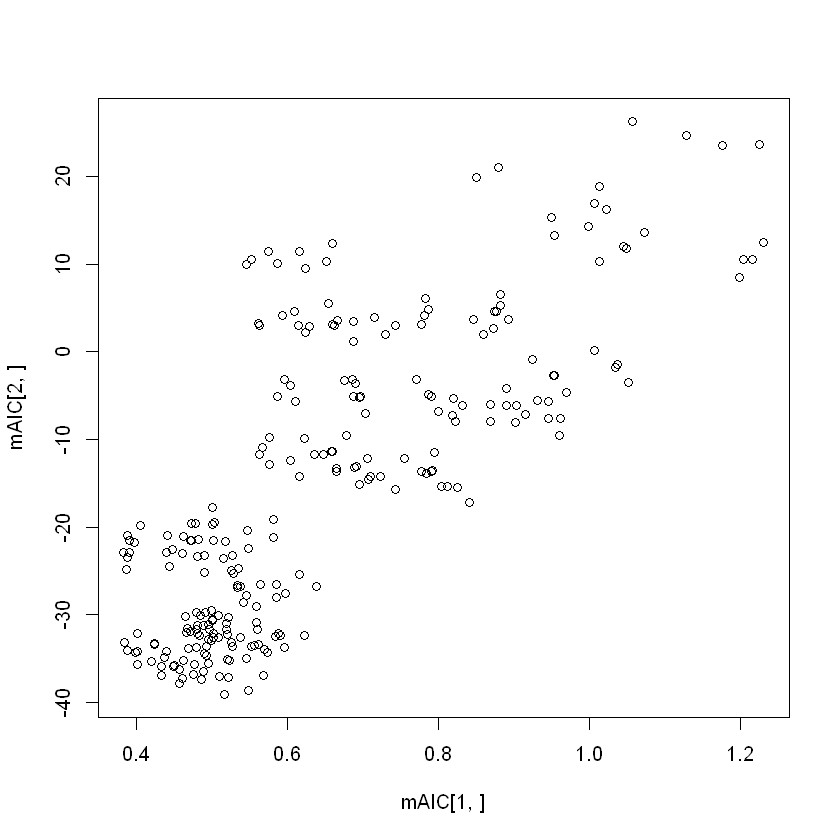

In [38]:
library(ElemStatLearn)                     #加载ElemStatLearn包

data(prostate)                             #加载prostate数据集

data = prostate             

p = dim(data)[2]-2                         #计算自变量个数

datatr = data[data[,p+2],1:(p+1)]          #获得训练集  

datate = data[!data[,p+2],1:(p+1)]         #获得测试集 

Z = turnbits_rec(p)                        #计算二进制矩阵

mAIC = apply(Z,1,bestlm,datatr,datate)     #进行最优子集回归

names(data)[1:p][Z[which.min(mAIC[1,]),]]  #按测试误差最小选出最优模型

names(data)[1:p][Z[which.min(mAIC[2,]),]]  #按AIC最小选择最优模型
#min(mAIC[2,])
plot(mAIC[1,], mAIC[2,])

In [24]:
head(data)
lm1 <- lm(lpsa~.,data[,-10])
extractAIC(lm1)
AIC(lm1)


lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
-0.5798185,2.769459,50,-1.386294,0,-1.386294,6,0,-0.4307829,TRUE
-0.9942523,3.319626,58,-1.386294,0,-1.386294,6,0,-0.1625189,TRUE
-0.5108256,2.691243,74,-1.386294,0,-1.386294,7,20,-0.1625189,TRUE
-1.2039728,3.282789,58,-1.386294,0,-1.386294,6,0,-0.1625189,TRUE
0.7514161,3.432373,62,-1.386294,0,-1.386294,6,0,0.3715636,TRUE
-1.0498221,3.228826,50,-1.386294,0,-1.386294,6,0,0.7654678,TRUE


[1]   9.00000 -60.77886

[1] 216.4952

In [28]:
fam1 = formula(paste("lpsa~",paste(names(data)[1:p][Z[which.min(mAIC[1,]),]],collapse = "+"),sep=""))
summary( lm(fam1,datatr) )


Call:
lm(formula = fam1, data = datatr)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6061 -0.5034  0.1559  0.5407  1.7078 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.27397    1.02245   1.246   0.2174    
lcavol       0.59521    0.10632   5.598 5.05e-07 ***
svi          0.53603    0.29895   1.793   0.0778 .  
gleason      0.04109    0.15768   0.261   0.7953    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8191 on 63 degrees of freedom
Multiple R-squared:  0.561,	Adjusted R-squared:  0.5401 
F-statistic: 26.84 on 3 and 63 DF,  p-value: 2.653e-11


In [31]:
fam2 = formula(paste("lpsa~",paste(names(data)[1:p][Z[which.min(mAIC[2,]),]],collapse = "+"),sep=""))
summary( lm(fam2,datatr) )


Call:
lm(formula = fam2, data = datatr)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.65425 -0.34471 -0.05615  0.44380  1.48952 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.259062   1.025170   0.253   0.8014    
lcavol       0.573930   0.105069   5.462 9.88e-07 ***
lweight      0.619209   0.218560   2.833   0.0063 ** 
age         -0.019480   0.013105  -1.486   0.1425    
lbph         0.144426   0.069812   2.069   0.0430 *  
svi          0.741781   0.294451   2.519   0.0145 *  
lcp         -0.205417   0.109424  -1.877   0.0654 .  
pgg45        0.008945   0.004099   2.182   0.0331 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7064 on 59 degrees of freedom
Multiple R-squared:  0.6943,	Adjusted R-squared:  0.658 
F-statistic: 19.14 on 7 and 59 DF,  p-value: 4.496e-13


In [41]:
mAIC                 # 两行，每行是一种方法下各种子集的数值
names(data)[1:p]
Z[which.min(mAIC[1,]),]

1.056733,0.4797387,1.013428,0.4924823,1.128225,0.4818105,1.049879,0.4800778,1.176626,0.5412412,...,0.6219652,0.4900704,0.8895303,0.587331,0.7778952,0.5678184,0.8901999,0.5584814,0.7544443,0.521274
26.293061,-23.3736091,10.307136,-33.6167964,24.727855,-21.4231914,11.772160,-32.1146884,23.493027,-28.5723735,...,-9.8715258,-34.4150179,-6.1337300,-32.170672,-13.6013826,-36.9137213,-4.1342817,-30.9116454,-12.1179586,-37.127661


[1] "lcavol"  "lweight" "age"     "lbph"    "svi"     "lcp"     "gleason"
[8] "pgg45"

[1]  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE